In [4]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import subprocess
export_folder = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing"
from scipy.stats import ttest_ind
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import LinearRegression
from lifelines.statistics import logrank_test
from tqdm import tqdm
from sklearn.cluster import AgglomerativeClustering
from glob import glob
from scipy import stats
from scipy.stats import pearsonr, levene
import os

In [5]:
pheno_cols = ["CCA"]
EUR_path_interval = "%s/genetic_score/EUR_interval" % export_folder
EUR_path = "%s/genetic_score/EUR" % export_folder
tag = "25_oct"

# Manhattan plot

In [6]:
gws = []
#for c in tqdm(pheno_cols):
for c in tqdm(pheno_cols):
    gw = pd.read_csv("%s/%s/bolt_res_feb_%s" % (export_folder,tag,c),sep="\t")
    gw["pheno"] = c
    gw.P_BOLT_LMM = gw.P_BOLT_LMM.astype(float)
    gws.append(gw)
gw = pd.concat(gws,axis=0,copy=False)
gw.rename(columns={"P_BOLT_LMM":"P"},inplace=True)

100%|██████████| 1/1 [00:11<00:00, 11.26s/it]


In [7]:
gw["POS"] = gw["BP"]
for ch in range(1,23):
    gw.loc[gw.CHR > ch,"POS"] += gw.loc[gw.CHR == ch,"BP"].max()
gw_ = gw.loc[gw.P < 1e-3]

In [8]:
UKBB_SNPS = []
for chrom in tqdm(range(1,23)):
    with open("%s/UKBB_SNPS_CHR%d.snplist" % (export_folder, chrom)) as f:
        UKBB_SNPS += [c[:-1] for c in f.readlines()]

print(len(UKBB_SNPS))
print(UKBB_SNPS[:10])

gw_["IN_UKBB"] = gw_.SNP.isin(UKBB_SNPS)
print(gw_["IN_UKBB"].mean())

100%|██████████| 22/22 [01:23<00:00,  3.80s/it]


93095623
['rs367896724', 'rs540431307', 'rs201106462', 'rs548419688', 'rs568405545', 'rs534229142', 'rs537182016', 'rs572818783', 'rs538322974', '1:10616_CCGCCGTTGCAAAGGCGCGCCG_C']
0.9246514910887594


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


# Select significant SNPs

## Prepare

In [9]:
cov = pd.read_csv("%s/%s/covars.csv" % (export_folder, tag), sep="\t")
phenotypes = pd.read_csv("%s/%s/phenotypes.csv" % (export_folder, tag), sep="\t")

phenotypes["ID"] = phenotypes["FID"].astype(str) + "_" + phenotypes["IID"].astype(str)
phenotypes = phenotypes.set_index("ID")[pheno_cols]

cov["ID"] = cov["FID"].astype(str) + "_" + cov["IID"].astype(str)
covar_cols = ["PC1","PC2","PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10","PLT","MPV","IPF","PCT","PDW","SEX","age_covar","cohort_covar"]
cov = cov.set_index("ID")[covar_cols]

X = pd.merge(cov,phenotypes,left_index=True,right_index=True)

## Utils

In [10]:
def get_p_value(source,target):
    lm = LinearRegression().fit(source,target)
    return pearsonr(target,lm.predict(source))[1]

In [11]:
def compare_p_values(X,model,augmented_model,Y):
    lm1 = LinearRegression().fit(X[model],Y)
    lm2 = LinearRegression().fit(X[augmented_model],Y)
    
    fit_1 = lm1.predict(X[model])
    fit_2 = lm2.predict(X[augmented_model])
    
    #residuals_1 = Y-fit_1
    #residuals_2 = Y-fit_2
    
    #p_val = levene(residuals_1,residuals_2,center="mean")[1]
    p_val = levene(fit_1,fit_2,center="mean")[1]
    
    return p_val

## Run

In [12]:
max_distance = 5e6 # from Dragana's
significant_SNPs = {}
P_threshold = 1e-8
genotypes = {}
for c in pheno_cols:
    print("Starting causal SNPs extraction")
    print(c)
    significant_SNPs[c] = []
    d = gw_.loc[gw_.pheno == c]
    hits = d.loc[(d.P < P_threshold) & (d.IN_UKBB)].copy()
    hits["region"] = AgglomerativeClustering(n_clusters=None,distance_threshold=max_distance,linkage="single")\
                        .fit(np.reshape(hits.POS.values,(-1,1)))\
                        .labels_
    for region, h in hits.groupby("region"):
        print("Region %d" % region)
        #if h.shape[0] == 1:
        #    significant_SNPs[c].append(h["SNP"].iloc[0])
        #    continue
        
        # Write the list of SNPS to a file
        SNP_list_file = "%s/conditional_analysis/significant_snps_%s_%s.txt" % (export_folder,c, tag)
        with open(SNP_list_file,"w") as file:
            for s in h.SNP.tolist():
                file.write("%s\n" % s)
        
        # Extract the table
        ch = int(h.CHR.iloc[0])
        gen_path = "%s/conditional_analysis/genotypes_region_%d_%s_CHR_%d" % (export_folder, region, c, ch)
        command = "/home/hv270/plink"
        command += " --bfile /home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/interval_genotypes/chr_%d" % ch
        command += " --extract %s" % SNP_list_file
        command += " --keep %s" % EUR_path_interval
        command += " --recode A-transpose --out %s" % gen_path
        p = subprocess.Popen(command,shell=True)
        p.wait()
        print("Done exporting genotypes")
        df = pd.read_csv("%s.traw" % (gen_path),sep="\t")
        df = df.set_index("SNP")
        ID_cols = [c for c in df.columns if c not in ["CHR","(C)M","POS","COUNTED","ALT"]]
        df = df[ID_cols].T
        var_cols = df.columns
        
        for var in var_cols:
            df.loc[df[var].isnull(),var] = df.loc[~df[var].isnull(),var].mean()
        
        G_X = pd.merge(df,X.copy(),left_index=True,right_index=True)
        
        G = G_X[var_cols]
        C = G_X[covar_cols]
        Y = G_X[[c]]
        
        # Adjust phenotype by covariates
        lm_covars = LinearRegression().fit(C,Y)
        Y[c] = Y[c] - lm_covars.predict(C)[:,0]
        
        univariable_p_values = [pearsonr(G[snp],Y[c])[1] for snp in G.columns]
        G = G[[G.columns[i] for i in np.argsort(univariable_p_values)]]
        
        model = [G.columns[0]]
        vars_not_in_model = lambda : [v for v in G.columns if v not in model]
        
        while True and (len(vars_not_in_model()) > 0):
            # Augment the model
            addition_p_values = pd.Series(index=vars_not_in_model(),dtype=float)
            for s in addition_p_values.index:
                #print("Trying to add %s" % s)
                LD = False
                for m in model:
                    R_2 = pearsonr(G[m],G[s])[0]**2
                    if R_2 >= 0.9:
                        addition_p_values.loc[s] = 1.
                        LD = True
                if LD: continue
                augmented_model = model + [s]
                addition_p_values.loc[s] = compare_p_values(G,model,augmented_model,Y[c])
            if addition_p_values.min() >= P_threshold:
                #print("Nothing to add, keep %s" % (model))
                break
            else:
                #print("Adding %s" % s)
                model.append(addition_p_values.sort_values().index[0])
            
            # Reduce the model
            reduce = True
            while reduce:
                reduce = False
                removal_p_values = pd.Series(index=model,dtype=float)
                for s in removal_p_values.index:
                    #print("Trying to remove %s" % s)
                    reduced_model = [m for m in model if m != s]
                    removal_p_values.loc[s] = compare_p_values(G,model,reduced_model,Y[c])
                if removal_p_values.min() <= P_threshold:
                    pass
                    # Go to augment
                else:
                    to_remove = removal_p_values.sort_values().index[-1]
                    print("Removing %s" % to_remove)
                    model = [m for m in model if m != to_remove]
                    reduce = True if len(model) >= 2 else False
                    # Go to reduce
        
        significant_SNPs[c] += model
        
        print("Done causal variant extraction. Kept %d out of %d" % (len(model),len(var_cols)))
        print("Hit : ")
        print(h.loc[h.SNP.isin(model),["CHR","BP","SNP","P"]])
        
        genotypes[(c, region)] = G[model]
    

Starting causal SNPs extraction
CCA
Region 0
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 1 out of 10
Hit : 
         CHR         BP       SNP             P
6692618   12  111973358  rs597808  3.100000e-12
Region 1
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 2 out of 14
Hit : 
         CHR       BP         SNP             P
5429659   10  3102379  rs11251684  3.900000e-09
5429877   10  3138009   rs2388595  1.200000e-10
Region 2
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 1 out of 76
Hit : 
         CHR         BP        SNP             P
4897307    8  106581528  rs6993770  1.300000e-33
Region 3
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 2 out of 611
Hit : 
         CHR         BP        SNP             P
3182100    5  122100398  rs6595407  6.400000e-40
3182995    5  122326008   rs425573  4.400000e-37
Region 4
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 1 out of 24
Hit : 
         CHR         BP         SNP             P
1867766    3  124453114  rs11916134  1.300000e-09
Region 5
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 1 out of 27
Hit : 
        CHR         BP         SNP             P
556208    1  207288392  rs17020993  4.300000e-19
Region 6
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 2 out of 23
Hit : 
         CHR         BP        SNP             P
3785331    6  110700656  rs9372251  5.500000e-11
3785373    6  110716722  rs2057150  2.300000e-09
Region 7
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 1 out of 3
Hit : 
         CHR        BP       SNP             P
8813355   20  57597971  rs415064  1.500000e-24
Region 8
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 1 out of 17
Hit : 
         CHR         BP         SNP             P
1384503    2  220087354  rs72955435  7.100000e-10
Region 9
Done exporting genotypes
Done causal variant extraction. Kept 1 out of 1
Hit : 
         CHR        BP        SNP             P
1657453    3  56849749  rs1354034  6.300000e-10


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [13]:
all_significant_SNPs = []
for c in significant_SNPs:
    all_significant_SNPs += significant_SNPs[c]
all_significant_SNPs = list(set(all_significant_SNPs))
recap = pd.DataFrame(index=all_significant_SNPs)
for c in pheno_cols:
    recap["causal_%s" % c] = recap.index.isin(significant_SNPs[c])


In [14]:
for c in pheno_cols:
    recap = pd.merge(recap,
                     gw.loc[gw.pheno == c,["SNP","BETA","P"]].set_index("SNP").rename(columns={"BETA":"BETA_%s" % c,
                                                                                               "P":"P_%s" % c}),
                     left_index=True,right_index=True)
recap = pd.merge(recap,gw.loc[gw.pheno == pheno_cols[0],["SNP","A1FREQ","CHR","BP"]].set_index("SNP"),left_index=True,right_index=True)

## Export

In [15]:
for c in pheno_cols:
    path = "%s/conditional_analysis/causal_SNPs_%s_%s.txt" % (export_folder,tag,c)
    with open(path,"w") as f:
        for snp in significant_SNPs[c]:
            f.write("%s\n" % snp)

In [16]:
path = "%s/conditional_analysis/causal_SNPs_%s_all.txt" % (export_folder,tag)
with open(path,"w") as f:
    for snp in all_significant_SNPs:
        f.write("%s\n" % snp)

In [18]:
recap.sort_values("P_CCA")

,causal_CCA,BETA_CCA,P_CCA,A1FREQ,CHR,BP
rs6595407,True,-0.120646,6.400000e-40,0.443586,5,122100398
rs425573,True,0.123047,4.400000e-37,0.670216,5,122326008
rs6993770,True,0.120753,1.300000e-33,0.713156,8,106581528
rs415064,True,0.224716,1.500000e-24,0.954646,20,57597971
rs17020993,True,0.125358,4.300000e-19,0.879310,1,207288392
rs597808,True,-0.065076,3.100000e-12,0.479086,12,111973358
rs9372251,True,-0.061588,5.500000e-11,0.561868,6,110700656
rs2388595,True,-0.059391,1.200000e-10,0.611246,10,3138009
rs1354034,True,-0.058354,6.300000e-10,0.404338,3,56849749
rs72955435,True,0.098276,7.100000e-10,0.911575,2,220087354


# Comparison w/ Dragana's GWAS

In [64]:
dgw = pd.read_excel("/home/hv270/sysmex2pf/dragana_GWAS.xlsx")
dgw = dgw.rename(columns={"rsID (where available)":"SNP",'Gene Symbol(s) for Most Serious Consequence':"Gene"})
dgw = dgw.loc[dgw["Associated Blood Index"].isin(["PLT#","PDW","MPV","PCT"])]

/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  """Entry point for launching an IPython kernel.


In [65]:
dgw.shape

(2825, 25)

In [66]:
for CH in range(1,23):
    # Write the list of SNPS to a file
    SNP_list_file = "%s/conditional_analysis/dragana_snps_chr_%d.txt" % (export_folder, CH)
    SNP_list = dgw.loc[(dgw["Chr (GRCh37)"] == CH) & dgw.SNP.str.contains("rs")].SNP.unique().tolist()
    SNP_list = [s for s in SNP_list if "rs" in s]
    with open(SNP_list_file,"w") as file:
        for s in SNP_list:
            file.write("%s\n" % s)

    # Extract the table
    gen_path = "%s/conditional_analysis/genotypes_dragana_CHR_%d" % (export_folder, CH)
    command = "/home/hv270/plink"
    command += " --bfile /home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/interval_genotypes/chr_%d" % CH
    command += " --extract %s" % SNP_list_file
    command += " --keep %s" % EUR_path_interval
    command += " --recode A-transpose --out %s" % gen_path
    p = subprocess.Popen(command,shell=True)
    p.wait()
    print("Done exporting genotypes of chrom %d" % CH)

Done exporting genotypes of chrom 1
Done exporting genotypes of chrom 2
Done exporting genotypes of chrom 3
Done exporting genotypes of chrom 4
Done exporting genotypes of chrom 5
Done exporting genotypes of chrom 6
Done exporting genotypes of chrom 7
Done exporting genotypes of chrom 8
Done exporting genotypes of chrom 9
Done exporting genotypes of chrom 10
Done exporting genotypes of chrom 11
Done exporting genotypes of chrom 12
Done exporting genotypes of chrom 13
Done exporting genotypes of chrom 14
Done exporting genotypes of chrom 15
Done exporting genotypes of chrom 16
Done exporting genotypes of chrom 17
Done exporting genotypes of chrom 18
Done exporting genotypes of chrom 19
Done exporting genotypes of chrom 20
Done exporting genotypes of chrom 21
Done exporting genotypes of chrom 22


In [67]:
gs = []
for CH in range(1,23):
    gen_path = "%s/conditional_analysis/genotypes_dragana_CHR_%d" % (export_folder, CH)
    df = pd.read_csv("%s.traw" % (gen_path),sep="\t")
    df = df.set_index("SNP")
    ID_cols = [c for c in df.columns if c not in ["CHR","(C)M","POS","COUNTED","ALT"]]
    df = df[ID_cols].T
    gs.append(df)
gen = pd.concat(gs,axis=1)
gen = gen.loc[:,~gen.columns.duplicated(keep="first")]

In [68]:
gen = gen.loc[gen.index.isin(X.index.tolist())]

In [70]:
for c in gen.columns:
    cond = gen[c].isnull()
    gen.loc[cond,c] = gen.loc[~cond,c].mean()
    
X_G = pd.merge(X, gen,left_index=True,right_index=True)
G_H = pd.concat([genotypes[key] for key in genotypes],axis=1)
G_H = G_H.loc[:,~G_H.columns.duplicated(keep="first")]

X_G_H = pd.merge(X_G,G_H[[s for s in G_H.columns if s not in X_G.columns]],left_index=True,right_index=True)

dgw.loc[dgw["Associated Blood Index"].isin(["PLT#","PDW","MPV","PCT"])].SNP.nunique()

2298

In [71]:
new_hits = []

all_d_hits = [s for s in dgw.SNP.unique().tolist() if s in gen.columns]

for pheno in pheno_cols:
    lm = LinearRegression().fit(X_G_H[cov.columns],X_G_H[pheno])
    adj_cov = X_G_H[pheno] - lm.predict(X_G_H[cov.columns])
    N_train = 20000
    for snp in G_H.columns:
        
        candidate_SNPs = dgw.loc[(dgw["Chr (GRCh37)"] == gw_.loc[gw_.SNP == snp,"CHR"].iloc[0])].SNP.unique().tolist()
        candidate_SNPs = [s for s in candidate_SNPs if np.abs(dgw.loc[dgw.SNP == s,"BP (GRCh37)"].iloc[0] - gw_.loc[gw_.SNP == snp,"BP"].mean()) <= 1e8]
        just_neighbors = [s for s in candidate_SNPs if s in gen.columns]
        
        lm1 = LinearRegression().fit(X_G_H[all_d_hits].iloc[:N_train],adj_cov.iloc[:N_train])
        pred1 = lm1.predict(X_G_H[all_d_hits].iloc[N_train:])
        r_1 = pearsonr(pred1,adj_cov.iloc[N_train:])[0]
        
        lm2 = LinearRegression().fit(X_G_H[just_neighbors].iloc[:N_train],adj_cov.iloc[:N_train])
        pred2 = lm2.predict(X_G_H[just_neighbors].iloc[N_train:])
        r_2 = pearsonr(pred2,adj_cov.iloc[N_train:])[0]
        print(r_1,r_2, len(just_neighbors))
        if r_1 < r_2:
            print("Better to take only neighbors")
        snps_to_take = all_d_hits if np.abs(r_2) < np.abs(r_1) else just_neighbors
        
        lm = LinearRegression().fit(X_G_H[snps_to_take],adj_cov)
        adj_D = adj_cov - lm.predict(X_G_H[snps_to_take])
        p = pearsonr(adj_D,X_G_H[snp])[1]
        print("%s - %s - %.2e" % (pheno, snp, p))
        if p < 1e-8 and p not in new_hits:
            new_hits.append(snp)

0.2269558049234696 0.05978162801586334 94
CCA - rs597808 - 7.91e-01
0.2269558049234696 0.05047170662674641 64
CCA - rs11251684 - 6.84e-01
0.2269558049234696 0.05047170662674641 64
CCA - rs2388595 - 7.05e-01
0.2269558049234696 0.060868087278596286 65
CCA - rs6993770 - 1.00e+00
0.2269558049234696 0.05232593540175795 93
CCA - rs6595407 - 8.21e-01
0.2269558049234696 0.05232593540175795 93
CCA - rs425573 - 1.92e-02
0.2269558049234696 0.0675987337611067 118
CCA - rs11916134 - 1.00e+00
0.2269558049234696 0.0814245677654351 119
CCA - rs17020993 - 3.03e-01
0.2269558049234696 0.047695282901491075 129
CCA - rs9372251 - 7.28e-01
0.2269558049234696 0.047695282901491075 129
CCA - rs2057150 - 9.95e-01
0.2269558049234696 0.08374202305544716 91
CCA - rs415064 - 1.00e+00
0.2269558049234696 0.051014836245411935 66
CCA - rs72955435 - 3.77e-01
0.2269558049234696 0.06115286201799449 93
CCA - rs1354034 - 1.00e+00


In [72]:
def get_lm_info(X,y,predictions,lm):

    #newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X))
    #MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))
    params = np.append(lm.intercept_,lm.coef_)
    # Note if you don't want to use a DataFrame replace the two lines above with
    newX = np.append(np.ones((len(X),1)), X, axis=1)
    MSE = (sum((y-predictions)**2))/(len(newX)-len(newX[0]))

    var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
    sd_b = np.sqrt(var_b)
    ts_b = params/ sd_b

    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(newX[0])))) for i in ts_b]

    sd_b = np.round(sd_b,3)
    ts_b = np.round(ts_b,3)
    #p_values = np.round(p_values,3)
    params = np.round(params,4)

    myDF3 = pd.DataFrame()
    myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["P"] = [params,sd_b,ts_b,p_values]
    myDF3["P"] = np.clip(myDF3["P"],a_min=1e-40,a_max=1)
    return myDF3.iloc[1:] # Don't return offset

In [73]:
def plot_correlations(X, cols):
    S = X[cols].values
    S = S - np.mean(S,axis=0)
    corr = np.abs((S.T @ S) / (S.shape[0]**2))
    np.fill_diagonal(corr, 0.)
    
    plt.figure()
    plt.imshow(corr,vmin=0.,vmax=1e-6)

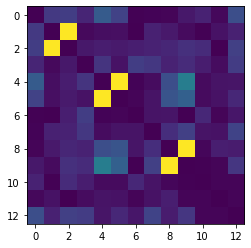

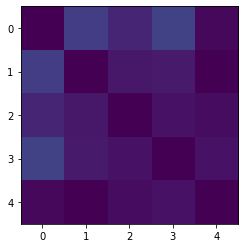

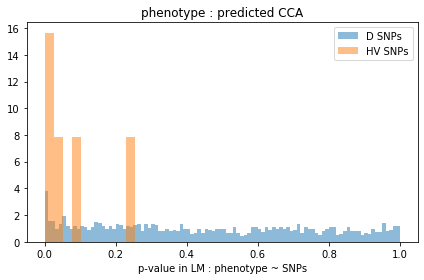

In [84]:
all_d_hits = [s for s in dgw.SNP.unique().tolist() if s in gen.columns]

for pheno in pheno_cols:
    lm = LinearRegression().fit(X_G_H[cov.columns],X_G_H[pheno])
    adj_cov = X_G_H[pheno] - lm.predict(X_G_H[cov.columns])
    
    plot_correlations(X_G_H,significant_SNPs[pheno])
    
    to_remove = []
    
    for i in range(len(significant_SNPs[pheno])):
        for j in range(i+1,len(significant_SNPs[pheno])):
            s1 = significant_SNPs[pheno][i]
            s2 = significant_SNPs[pheno][j]
            if s2 in to_remove: continue
            if s1 in to_remove: continue
            if pearsonr(X_G_H[s1],X_G_H[s2])[0]**2 > 1e-4:
                to_remove.append(s2)
    
    uncorr_significant_snps = [s for s in significant_SNPs[pheno] if s not in to_remove]
    
    plot_correlations(X_G_H,uncorr_significant_snps)
    
    all_hits = list(set(all_d_hits + uncorr_significant_snps))
    #all_hits = significant_SNPs[pheno]
    lm = LinearRegression().fit(X_G_H[all_hits],adj_cov)
    pred = lm.predict(X_G_H[all_hits])
    
    lm_info = get_lm_info(X_G_H[all_hits],adj_cov,pred,lm)
    lm_info["P_alone"] = [pearsonr(X_G_H[s],adj_cov)[1] for s in all_hits]
    lm_info["SNP"] = all_hits
    lm_info.set_index("SNP",inplace=True)
    
    plt.figure()
    plt.hist(lm_info["P"],density=True,bins=100,alpha=.5,label="D SNPs")
    plt.hist(lm_info.loc[uncorr_significant_snps,"P"],density=True,alpha=.5,label="HV SNPs")
    plt.xlabel("p-value in LM : phenotype ~ SNPs")
    plt.title("phenotype : predicted %s" % pheno)
    plt.legend()
    plt.tight_layout()

In [85]:
illustrate = pd.merge(gw.loc[gw.pheno == pheno],lm_info,left_on="SNP",right_index=True,how="inner")

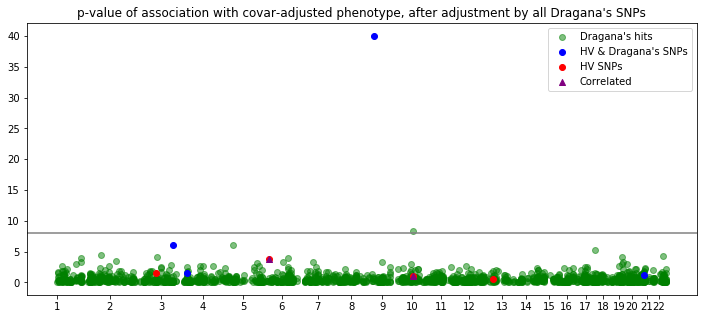

In [86]:
is_HV = illustrate.SNP.isin(significant_SNPs[pheno])
is_D = illustrate.SNP.isin(all_d_hits)
is_corr = illustrate.SNP.isin([significant_SNPs[pheno][i] for i in corr_snps])
plt.figure(figsize=(12,5))
plt.scatter(illustrate.loc[~is_HV,"POS"],-np.log10(illustrate.loc[~is_HV,"P_y"]),c="green",alpha=.5,label="Dragana's hits")
plt.scatter(illustrate.loc[is_HV & is_D,"POS"],-np.log10(illustrate.loc[is_HV & is_D,"P_y"]),c="blue",alpha=1,label="HV & Dragana's SNPs")
plt.scatter(illustrate.loc[is_HV & ~is_D,"POS"],-np.log10(illustrate.loc[is_HV & ~is_D,"P_y"]),c="red",alpha=1,label="HV SNPs")
plt.scatter(illustrate.loc[is_HV & is_corr,"POS"],-np.log10(illustrate.loc[is_HV & is_corr,"P_y"]),c="purple",marker="^",alpha=1,label="Correlated")
plt.axhline(8,c="grey")
plt.title("p-value of association with covar-adjusted phenotype, after adjustment by all Dragana's SNPs")
plt.xticks([gw.loc[gw.CHR == i,"POS"].min() for i in range(1,23)],[str(i) for i in range(1,23)]);
plt.legend();

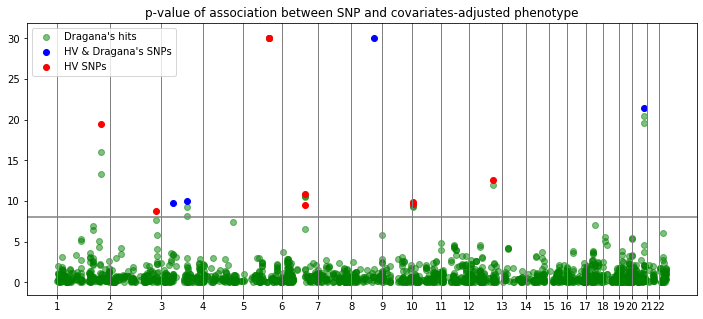

In [32]:
is_HV = illustrate.SNP.isin(significant_SNPs[pheno])
is_D = illustrate.SNP.isin(all_d_hits)
plt.figure(figsize=(12,5))
plt.scatter(illustrate.loc[~is_HV,"POS"],       np.clip(-np.log10(illustrate.loc[~is_HV,"P_alone"]),0,30),c="green",alpha=.5,label="Dragana's hits")
plt.scatter(illustrate.loc[is_HV & is_D,"POS"], np.clip(-np.log10(illustrate.loc[is_HV & is_D,"P_alone"]),0,30),c="blue",alpha=1,label="HV & Dragana's SNPs")
plt.scatter(illustrate.loc[is_HV & ~is_D,"POS"],np.clip(-np.log10(illustrate.loc[is_HV & ~is_D,"P_alone"]),0,30),c="red",alpha=1,label="HV SNPs")

plt.axhline(8,c="grey")
plt.title("p-value of association between SNP and covariates-adjusted phenotype")
for c in [gw.loc[gw.CHR == i,"POS"].min() for i in range(1,23)]:
    plt.axvline(c,color="grey",lw=1)
plt.xticks([gw.loc[gw.CHR == i,"POS"].min() for i in range(1,23)],[str(i) for i in range(1,23)]);
plt.legend();

# Look in Dragana's GWAS

In [33]:
dgw = pd.read_excel("/home/hv270/sysmex2pf/dragana_GWAS.xlsx")
dgw = dgw.rename(columns={"rsID (where available)":"SNP",'Gene Symbol(s) for Most Serious Consequence':"Gene"})
dgw = dgw.loc[dgw["SNP"].isin(all_significant_SNPs)]

/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  """Entry point for launching an IPython kernel.


In [34]:
sysmex_pheno = ~dgw.pivot_table(aggfunc="first",index="SNP",columns="Associated Blood Index",values=["Gene"])["Gene"].isnull()

In [35]:
genes = dgw.groupby("SNP")[["Gene"]].first()
genes

,Gene
SNP,
rs11916134,UMPS
rs1354034,ARHGEF3
rs415064,TUBB1
rs6993770,ZFPM2


In [36]:
sysmex_pheno["Dragana GWAS traits"] = ""
for c in sysmex_pheno.columns:
    if c == "Dragana GWAS traits": continue
    sysmex_pheno.loc[sysmex_pheno[c],"Dragana GWAS traits"] += "%s " % c

In [37]:
recap = pd.merge(recap,sysmex_pheno[["Dragana GWAS traits"]],how="left",left_index=True,right_index=True).fillna("")

In [38]:
import myvariant
mv = myvariant.MyVariantInfo()

gene_names = {}
to_query = recap.index.tolist()
a = mv.querymany(to_query,scopes='dbsnp.rsid', build="hg38",fetchall=False)

for i in range(len(a)):
    q = a[i]["query"]
    try:
        gene = a[i]["cadd"]["gene"]["genename"]
    except:
        try:
            gene = a[i]["dbsnp"]["gene"]["symbol"]
        except:
            try:
                gene = a[i]["wellderly"]["genename"]
            except:
                try:
                    gene = a[i]["snpeff"]["ann"]["genename"]
                except:
                    try:
                        gene = a[i]["snpeff"]["ann"][0]["genename"]
                    except:
                        if q == "rs111763415":
                            gene = "SUFU"
                        else:
                            gene = "not found"
    if q in gene_names:
        gene_names[q].append(gene)
    else:
        gene_names[q] = [gene]

for q in gene_names:
    recap.loc[q,"genes"] = ", ".join(list(set(gene_names[q])))

querying 1-13...done.
Finished.
7 input query terms found dup hits:
	[('rs2057150', 2), ('rs597808', 3), ('rs415064', 2), ('rs17020993', 2), ('rs9372251', 2), ('rs112516
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [39]:
# for gene ontology
for gene in recap.genes.unique().tolist():
    print(gene.split("-")[0])

ZFPM2
ATG9A
DDO
ARHGEF3
ATXN2
LOC101927379
SNX24
TUBB1
C4BPA
METTL24
LOC101927824
UMPS
PFKP


In [40]:
recap.sort_values(["CHR","BP"])

,causal_CCA,BETA_CCA,P_CCA,A1FREQ,CHR,BP,Dragana GWAS traits,genes
rs17020993,True,0.125358,4.300000e-19,0.879310,1,207288392,,C4BPA
rs72955435,True,0.098276,7.100000e-10,0.911575,2,220087354,,ATG9A
rs1354034,True,-0.058354,6.300000e-10,0.404338,3,56849749,HLSR# HLSR% LYMPH# LYMPH% MPV PCT PLT# RET# RET%,ARHGEF3
rs11916134,True,0.062459,1.300000e-09,0.730533,3,124453114,PCT,UMPS
rs6595407,True,-0.120646,6.400000e-40,0.443586,5,122100398,,LOC101927379-SNX2
rs425573,True,0.123047,4.400000e-37,0.670216,5,122326008,,SNX24
rs9372251,True,-0.061588,5.500000e-11,0.561868,6,110700656,,METTL24-DDO
rs2057150,True,-0.066250,2.300000e-09,0.732599,6,110716722,,DDO
rs6993770,True,0.120753,1.300000e-33,0.713156,8,106581528,MPV PCT PDW PLT#,ZFPM2
rs11251684,True,-0.070441,3.900000e-09,0.176845,10,3102379,,LOC101927824


In [35]:
recap.to_csv("/home/hv270/sysmex2pf/recap_%s.csv" % tag)

# Manhattan plot

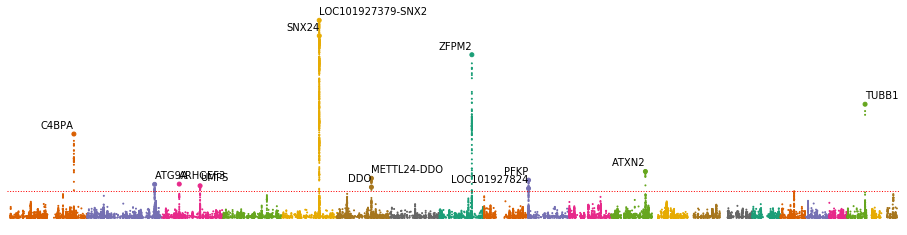

In [41]:
cmap = plt.get_cmap("Dark2")
for c in pheno_cols:
    g = gw_.loc[gw_.pheno == c]
    g.P = np.clip(g.P,a_min=1e-40,a_max=1)
    plt.figure(figsize=(16,4))
    plt.scatter(g.POS,-np.log10(g.P),c=cmap(g.CHR % 8),s=1 + 15*g.SNP.isin(significant_SNPs[c]))
    plt.xticks([g.loc[g.CHR == ch,"POS"].min() for ch in range(1,23)],[str(ch) for ch in range(1,23)])
    plt.axhline(8,c="red",ls=":",lw=1)
    written_genes = []
    for i, snp in enumerate(recap.loc[recap["causal_%s" % c]].index):
        pos = g.loc[g.SNP == snp,"POS"] #+ (i % 2)*1e7 - 5e6
        height = 1 - np.log10(g.loc[g.SNP == snp,"P"])
        gene = recap.loc[snp,"genes"]
        if gene not in written_genes:
            plt.text(pos, height,gene,ha="right" if i % 2 == 0 else "left")
            written_genes.append(gene)
    plt.axis("off")
    plt.xlim((g.POS.min()-1e7,g.POS.max() + 1e7))

# Compute score

In [42]:
raise "Error"

TypeError: exceptions must derive from BaseException

In [43]:
causal_snps = {}
for c in pheno_cols:
    causal_path = "%s/conditional_analysis/causal_SNPs_%s_%s.txt" % (export_folder,tag,c)
    causal_snps[c] = [c[:-1] for c in open(causal_path,"r").readlines()]

In [44]:
good = {}
for c in pheno_cols:
    good[c] = gw.loc[(gw.pheno == c) & (gw.SNP.isin(causal_snps[c]))]

In [45]:
pheno_cols

['CCA']

In [46]:
first_pheno = pheno_cols[0]
betas = good[first_pheno][["SNP","BETA"]].rename(columns={"BETA":first_pheno})
for c in pheno_cols[1:]:
    betas = pd.merge(betas,good[c][["SNP","BETA"]].rename(columns={"BETA":c}),
                     left_on="SNP",right_on="SNP",how="outer")
betas = pd.merge(betas,gw.loc[gw.pheno == first_pheno,["SNP","ALLELE1"]],left_on="SNP",right_on="SNP",how="left")
betas = betas[["SNP","ALLELE1"] + pheno_cols]
betas.fillna(0,inplace=True)
assert betas.shape[0] == betas.SNP.nunique()

In [44]:
good_chroms = []
for c in good:
    good_chroms += good[c].CHR.unique().tolist()
good_chroms = list(set(good_chroms))
print(good_chroms)

[1, 2, 3, 4, 5, 9, 10, 11, 12, 13, 16, 17, 19, 20, 22]


In [45]:
betas.head()

,SNP,ALLELE1,CCA
0,rs1764405,A,0.074991
1,rs12041331,G,-0.133169
2,rs2180747,G,0.071455
3,rs10914144,T,0.087074
4,rs1124025,C,-0.063734


In [46]:
if not os.path.exists("%s/Genetic_score_Sysmex_traits/%s" % (export_folder,tag)):
    os.mkdir("%s/Genetic_score_Sysmex_traits/%s" % (export_folder,tag))

In [47]:
betas_path = "%s/Genetic_score_Sysmex_traits/betas.csv" % (export_folder)
betas.to_csv(betas_path,
            sep="\t",index=False)

n_splits = 16

all_causal_path = "%s/conditional_analysis/causal_SNPs_%s_all.txt" % (export_folder,tag)

for chrom in good_chroms:
    command = "/home/hv270/Plink2/plink2"
    command += " --bgen /rds/project/wja24/rds-wja24-uk-biobank-gen/bgen/ukb_imp_chr%s_v3.bgen" % chrom
    command += " --sample /rds/project/wja24/rds-wja24-uk-biobank-gen/13745_specific/sample/ukb13745_imp_chr%s_v3_s487378.sample" % chrom
    #command += " --extract %s" % causal_snps_path
    command += " --keep %s" % EUR_path
    command += " --extract %s" % all_causal_path
    command += " --score %s header-read" % betas_path
    if len(pheno_cols) > 1:
        command += " --score-col-nums 3-%d" % (2 + len(pheno_cols))
    else:
        command += " --score-col-nums 3"
    command += " --out %s/Genetic_score_Sysmex_traits/%s/good_score_chr%s" % (export_folder,tag,chrom)
    command += " --threads %d" % n_splits

    f_name = "/home/hv270/interval_slurm_calls/call_gs_chr_%s_%s.sh" % (chrom,tag)
    f = open(f_name,"w+")
    f.write("#!/bin/sh\n")

    f.write("#SBATCH -J chr%s\n" % (chrom))
    f.write("#SBATCH -A ASTLE-SL2-CPU\n")
    f.write("#SBATCH -N 1\n")
    f.write("#SBATCH -n %d\n" % n_splits)
    f.write("#SBATCH --time=8:30:00\n")
    f.write("#SBATCH -p skylake-himem\n")
    f.write("#SBATCH --output=/home/hv270/slurm_log/%s_%s_%s.out\n" % ("GS",tag,chrom))
    f.write("export OMP_NUM_THREADS=%d\n" % n_splits)

    f.write(". /etc/profile.d/modules.sh\n")
    f.write("module purge\n")
    f.write("module load rhel7/default-peta4\n")
    f.write(command)
    f.close()

    print("Submitting %s" % (chrom))
    p = subprocess.Popen("sbatch %s" % f_name,shell=True)
    p.wait()

Submitting 1
Submitting 2
Submitting 3
Submitting 4
Submitting 5
Submitting 9
Submitting 10
Submitting 11
Submitting 12
Submitting 13
Submitting 16
Submitting 17
Submitting 19
Submitting 20
Submitting 22


# Read PLINK GWAS